In [1]:
#Importamos las librerías que serán usadas
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
#Cargamos con pandas los datasets que serán usando para hacer nuestro EDA
df_movies = pd.read_csv('C:\Python\HENRY-Data-Science\Proyecto_1\Datasets\movies_dataset.csv', encoding='utf-8')
df_credits = pd.read_csv('C:\Python\HENRY-Data-Science\Proyecto_1\Datasets\credits.csv', encoding='utf-8')

C:\Users\house\AppData\Local\Temp\ipykernel_33468\1950063624.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv('C:\Python\HENRY-Data-Science\Proyecto_1\Datasets\movies_dataset.csv', encoding='utf-8')


In [3]:
print(df_movies.shape)
df_movies.head(1)

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [4]:
print(df_credits.shape)
df_credits.head(1)

(45476, 3)


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862


In [5]:
#Normalizamos las columna 'id' para poder hacer un join entre ambos datasets
df_movies['id'] = pd.to_numeric(df_movies['id'], errors='coerce')
df_movies.dropna(subset=['id'], inplace=True)
df_movies['id'].astype('int64')

0           862
1          8844
2         15602
3         31357
4         11862
          ...  
45461    439050
45462    111109
45463     67758
45464    227506
45465    461257
Name: id, Length: 45463, dtype: int64

In [6]:
df_joined = df_movies.merge(df_credits, on='id', how='outer') #hacemos el join

#Tratamos el nuevo dataframe reduciendo el tamaño, para es definimos los idiomas a los más conocido, sacamos las películas más antiguas
#y las de popularidad menor a 2.0
languages = ['en', 'fr', 'it', 'de', 'ar', 'es','uk']
df_joined['popularity'] = pd.to_numeric(df_joined['popularity'], downcast='signed', errors='coerce')
df_joined.query("status == 'Released' and popularity >= 2.0 and release_date >= '1950-1-1' and original_language == @languages", inplace=True)
print(df_joined.shape)
df_joined.head(1)

(14133, 26)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
2,False,NaN,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,5.0,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,...,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,False,6.5,539.0,"[{'cast_id': 42, 'character': 'Ted the Bellhop...","[{'credit_id': '52fe420dc3a36847f800011b', 'de..."


In [7]:
print(df_joined.shape)
df_joined.columns

(14133, 26)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [8]:
#Creamos otro dataframe sólo con las columnas de interés para nuestro modelo
df_eda = df_joined[['id', 'belongs_to_collection', 'genres', 'overview', 'title', 'cast', 'crew']]
df_eda.dropna(inplace=True) #Eliminamos los datos no válidos
print(df_eda.shape)
df_eda.head(1)

(2397, 7)


C:\Users\house\AppData\Local\Temp\ipykernel_33468\287227341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda.dropna(inplace=True) #Eliminamos los datos no válidos


,id,belongs_to_collection,genres,overview,title,cast,crew
4,11.0,"{'id': 10, 'name': 'Star Wars Collection', 'po...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",Princess Leia is captured and held hostage by ...,Star Wars,"[{'cast_id': 3, 'character': 'Luke Skywalker',...","[{'credit_id': '52fe420dc3a36847f8000437', 'de..."


In [9]:
#Creamos las siguientes funciones para extraer la información de las columnas anidadas

#Esta función itera por cada una de las filas de la columna y extrae la clave 'name'
def extraer(texto):
    lista = []    
    datos = ast.literal_eval(texto)    #metodo literal_eval() convierte el texto en un objeto python como lista o diccionario
    if isinstance(datos, list):     #Verificamos que sea una lista e iteramos sobre cada elemento de ella para acceder a cada elemento
        for item in datos:
            if isinstance(item, dict) and 'name' in item: #Verificamos que sea un diccionario e iteramos sobre cada elemento de el para extraer   
                lista.append(item['name'])                  #la clave 'name' y agregarla a la lista
    elif isinstance(datos, dict) and 'name' in datos:
        lista.append(datos['name'])    
    return lista  #Devolvemos la lista con todos los valores de la clave 'name'

#Esta función itera por cada una de las filas de la columna y extrae la clave 'name', pero le agrega una condicion
def directores(texto):
    lista = []    
    for i in ast.literal_eval(texto):   #metodo literal_eval() convierte el texto en un objeto python como lista o diccionario
        if i['job'] == 'Director':   #se condiciona a sólo extraer los elementos cuando la columna 'job' tiene el valor de 'Director'
            lista.append(i['name'])
    return lista

#función que sirve para normalizar las palabras y oraciones quietando todo los espacios en ellas
def del_espacios(texto):
    lista = []
    for i in texto:
        lista.append(i.replace(" ", ""))
    return lista


In [10]:
#Se aplican las funciones anteriores sobre las columnas para normalizar y extraer sólo las palabras que sirven para el modelo

df_eda['genres'] = df_eda['genres'].apply(extraer)
df_eda['cast'] = df_eda['cast'].apply(extraer)
df_eda['cast'] = df_eda['cast'].apply(lambda x: x[0:3]) #Esta función sólo elije a los 3 principales actores que se encuentran en la fila
df_eda['belongs_to_collection'] = df_eda['belongs_to_collection'].apply(extraer)
df_eda['crew'] = df_eda['crew'].apply(directores)
df_eda['overview'] = df_eda['overview'].apply(lambda x: x.split()) #convertimos la cadena de texto en un lista de palabras

df_eda['belongs_to_collection'] = df_eda['belongs_to_collection'].apply(del_espacios)
df_eda['genres'] = df_eda['genres'].apply(del_espacios)
df_eda['cast'] = df_eda['cast'].apply(del_espacios)
df_eda['crew'] = df_eda['crew'].apply(del_espacios)

#aplicamos un funcion lambda para eliminar espacios vacíos en la lista
df_eda['overview'] = df_eda['overview'].apply(lambda x: list(filter(lambda y: y and y.strip(), x)))

C:\Users\house\AppData\Local\Temp\ipykernel_33468\3270208206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['genres'] = df_eda['genres'].apply(extraer)
C:\Users\house\AppData\Local\Temp\ipykernel_33468\3270208206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['cast'] = df_eda['cast'].apply(extraer)
C:\Users\house\AppData\Local\Temp\ipykernel_33468\3270208206.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [11]:
#Creamos una nueva columna que une todas las palabras ya tratadas en una sola
df_eda['tags'] = df_eda['belongs_to_collection'] + df_eda['genres'] + df_eda['overview'] + df_eda['cast'] + df_eda['crew']

df_eda.head()

C:\Users\house\AppData\Local\Temp\ipykernel_33468\1580857825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['tags'] = df_eda['belongs_to_collection'] + df_eda['genres'] + df_eda['overview'] + df_eda['cast'] + df_eda['crew']


,id,belongs_to_collection,genres,overview,title,cast,crew,tags
4,11.0,[StarWarsCollection],"[Adventure, Action, ScienceFiction]","[Princess, Leia, is, captured, and, held, host...",Star Wars,"[MarkHamill, HarrisonFord, CarrieFisher]",[GeorgeLucas],"[StarWarsCollection, Adventure, Action, Scienc..."
5,12.0,[FindingNemoCollection],"[Animation, Family]","[Nemo,, an, adventurous, young, clownfish,, is...",Finding Nemo,"[AlbertBrooks, EllenDeGeneres, AlexanderGould]",[AndrewStanton],"[FindingNemoCollection, Animation, Family, Nem..."
9,16.0,[HeartofGoldCollection],"[Drama, Crime, Music]","[Selma,, a, Czech, immigrant, on, the, verge, ...",Dancer in the Dark,"[Björk, CatherineDeneuve, DavidMorse]",[LarsvonTrier],"[HeartofGoldCollection, Drama, Crime, Music, S..."
15,22.0,[PiratesoftheCaribbeanCollection],"[Adventure, Fantasy, Action]","[Jack, Sparrow,, a, freewheeling, 17th-century...",Pirates of the Caribbean: The Curse of the Bla...,"[JohnnyDepp, GeoffreyRush, OrlandoBloom]",[GoreVerbinski],"[PiratesoftheCaribbeanCollection, Adventure, F..."
16,24.0,[KillBillCollection],"[Action, Crime]","[An, assassin, is, shot, at, the, altar, by, h...",Kill Bill: Vol. 1,"[UmaThurman, LucyLiu, VivicaA.Fox]",[QuentinTarantino],"[KillBillCollection, Action, Crime, An, assass..."


In [12]:
#Eliminamos todas las demás columnas que nos sirvieron para crear la columna 'Tags' con la que trabajaremos nuestro modelo
#y reseteamos el índice
df_for_analisys = df_eda.drop(columns=['overview', 'belongs_to_collection', 'genres', 'cast', 'crew'])
df_for_analisys.reset_index(drop=True, inplace=True)


In [13]:
#convertimos cada lista de palabras en una cadena de texto en la que cada palabra está separada por un espacio.
df_for_analisys['tags'] = df_for_analisys['tags'].apply(lambda x: ' '.join(x))
print(df_for_analisys.shape)
df_for_analisys.head()

(2397, 3)


,id,title,tags
0,11.0,Star Wars,StarWarsCollection Adventure Action ScienceFic...
1,12.0,Finding Nemo,"FindingNemoCollection Animation Family Nemo, a..."
2,16.0,Dancer in the Dark,"HeartofGoldCollection Drama Crime Music Selma,..."
3,22.0,Pirates of the Caribbean: The Curse of the Bla...,PiratesoftheCaribbeanCollection Adventure Fant...
4,24.0,Kill Bill: Vol. 1,KillBillCollection Action Crime An assassin is...


In [14]:
#revisamos las dimensiones del dataframe
print(df_for_analisys.shape)

(2397, 3)


In [15]:
#Visualizamos el resultado
print(df_for_analisys['tags'].iloc[0])

StarWarsCollection Adventure Action ScienceFiction Princess Leia is captured and held hostage by the evil Imperial forces in their effort to take over the galactic Empire. Venturesome Luke Skywalker and dashing captain Han Solo team together with the loveable robot duo R2-D2 and C-3PO to rescue the beautiful princess and restore peace and justice in the Empire. MarkHamill HarrisonFord CarrieFisher GeorgeLucas


In [16]:
#Eliminamos los puntos y comas que pudiesen haber quedado entre medio
df_for_analisys['tags'] = df_for_analisys['tags'].str.replace(r'[.,]', '', regex=True)

In [17]:
#Guardamos el dataset que usaremos para crear el modelo
df_for_analisys.to_csv('C:\Python\HENRY-Data-Science\Proyecto_1\Datasets\dataset_recomendaciones.csv', index=False)

Creamos el modelo

In [18]:
#df_for_analisys = pd.read_csv('C:\Python\HENRY-Data-Science\Proyecto_1\Datasets\dataset_recomendaciones.csv')

In [19]:
#Vectorizamos convirtiendo la columna tags en una matriz numérica, donde cada fila de la matriz representa un conjunto de palabras (o "tags") 
# asociadas a cada película. Cada palabra tiene un puntaje basado en su importancia (TF-IDF) en el contexto de todos los documentos.

tv = TfidfVectorizer(max_features=2000, stop_words='english') #Limitamos la matriz con las 2000 palabras más significativas y pasamos el
                                                                # el parámetro 'stop_words=' para obviar las palabras sin aporte de significado (the, an, on, etc)

#transformamos cada entrada de tags en una matriz dispersa de características TF-IDF, que en el análisis de texto es usada para ponderar la importancia
#de una palabra en un documento específico considerando su frecuencia y la frecuencia inversa de ese texto en el documento, vale decir
#que las palabras que aparecen en muchos textos pierden ponderación

vector = tv.fit_transform(df_for_analisys['tags']) #Escalamos los datos
vector.shape


(2397, 2000)

In [20]:
#Creamos nuestra matriz de similaridad a través del método de coseno entre vectores

similaridad = cosine_similarity(vector)
similaridad

array([[1.        , 0.        , 0.        , ..., 0.0064844 , 0.00554536,
        0.01623254],
       [0.        , 1.        , 0.        , ..., 0.        , 0.03518496,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.0655497 , 0.        ,
        0.04016164],
       ...,
       [0.0064844 , 0.        , 0.0655497 , ..., 1.        , 0.        ,
        0.01752967],
       [0.00554536, 0.03518496, 0.        , ..., 0.        , 1.        ,
        0.00373225],
       [0.01623254, 0.        , 0.04016164, ..., 0.01752967, 0.00373225,
        1.        ]])

In [21]:
#Creamos una función de recomendación donde le pasamos el modelo hecho

def recomendacion(pelicula:str):
    pelicula = pelicula.title().strip() #Normalizamos el título

    #Verificamos que el título exista dentro del dataset y si no lo hace que lance un mensaje de error
    pelicula_fila = df_for_analisys[df_for_analisys['title'] == pelicula]
    if pelicula_fila.empty:
        raise ValueError("La película no fue encontrada")
    
    indice = pelicula_fila.index[0]

    #Se valida la matriz de similitud asegurándose de que esté cargada y bien configurada. De no estar configurada o cargada
    #lanza un mensaje de error

    if 'similaridad' not in globals() or len(similaridad) != len(df_for_analisys):
        raise ValueError("La matriz de similaridad no está definida correctamente o no coincide con los datos.")

    #Calcula la distancia de los vectores para  conseguir las películas más cercanas entre ellas
    distancia = sorted(list(enumerate(similaridad[indice])), reverse=True, key=lambda x: x[1])
    recomendaciones = []

    #Recorre las 5 primeras películas, dejando afuera el índice 0 ya que hace referencia a la misma película, y devuelve una lista
    for i in distancia[1:6]:
        recomendaciones = [df_for_analisys.iloc[i[0]].title for i in distancia[1:6]]
    return recomendaciones

In [26]:
#Probamos la función
recomendacion('hitman')

['From Russia with Love',
 'The Mechanic',
 'The Condemned 2',
 'The Bourne Supremacy',
 'Hitman: Agent 47']

In [23]:
def nube_palabras(pelicula:str):
    pelicula = pelicula.title().strip() #Normalizamos el título

    #Verificamos que el título exista dentro del dataset y si no lo hace que lance un mensaje de error
    pelicula_fila = df_for_analisys[df_for_analisys['title'] == pelicula]
    if pelicula_fila.empty:
        raise ValueError("La película no fue encontrada")

    pelicula_indice = pelicula_fila.index[0]

    # Obtener las películas más similares según la matriz de similaridad
    distancia = sorted(list(enumerate(similaridad[pelicula_indice])), reverse=True, key=lambda x: x[1])

    # Crear un diccionario con las películas y sus similitudes, pero se omite la película misma)
    frecuencias = {df_for_analisys.iloc[i[0]].title: i[1] for i in distancia[1:11]}

    # Se crear la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis")
    wordcloud.generate_from_frequencies(frecuencias)

    # Se plotea el resultado
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Películas similares a '{df_for_analisys.iloc[pelicula_indice].title}'")
    plt.show()

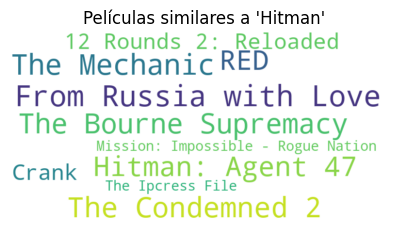

In [24]:
nube_palabras('hitman')

In [25]:
#Exportamos los archivos del dataset y la matriz de similaridad en formato pkl con el modulo pickle
#para así poder cargarla en el deploy de fastapi con render
pickle.dump(df_for_analisys, open('peliculas.pkl', 'wb'))
pickle.dump(similaridad, open('similaridad.pkl', 'wb'))